In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow import keras as kr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
# upload
print('Uploading...')
exp_matrix = pd.read_csv('/root/work/data/survival/stad_exp_surv', index_col=0)
label = pd.read_csv('/root/work/data/survival/stad_label_surv', index_col=0)
print('Uploading done!')

Uploading...
Uploading done!


In [3]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(train)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [3]:
# data preprocessing
x = exp_matrix.T

# str -> int
y = np.array(label['survival_label'].map({'LTS':0, 'STS':1}).astype(int)).reshape(label.shape[0],1)

In [12]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(218, 12411) (94, 12411) (218, 1) (94, 1)


In [11]:
model = Sequential()
model.add(Dense(8192, input_dim=train_x.shape[1], kernel_initializer='uniform', activation='LeakyReLU'))
# model.add(Dropout(0.1))
model.add(Dense(4096, kernel_initializer='uniform', activation='ReLU'))
model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))

model.compile(loss=kr.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
# model.compile(loss=[focal_loss(alpha=.5, gamma=2)], optimizer='adam', metrics=['accuracy'])

Epoch 1/30
7/7 [==============================] - 2s 204ms/step - loss: 93.5673 - accuracy: 0.6531 - val_loss: 9.6203 - val_accuracy: 0.8182
Epoch 2/30
7/7 [==============================] - 1s 184ms/step - loss: 24.7167 - accuracy: 0.7041 - val_loss: 7.2729 - val_accuracy: 0.8182
Epoch 3/30
7/7 [==============================] - 1s 193ms/step - loss: 11.8004 - accuracy: 0.7296 - val_loss: 16.6052 - val_accuracy: 0.7273
Epoch 4/30
7/7 [==============================] - 1s 185ms/step - loss: 9.1162 - accuracy: 0.7500 - val_loss: 8.7178 - val_accuracy: 0.5909
Epoch 5/30
7/7 [==============================] - 1s 183ms/step - loss: 5.0959 - accuracy: 0.7908 - val_loss: 5.8780 - val_accuracy: 0.8182
Epoch 6/30
7/7 [==============================] - 2s 257ms/step - loss: 2.8237 - accuracy: 0.8571 - val_loss: 36.9296 - val_accuracy: 0.0455
Epoch 7/30
7/7 [==============================] - 1s 189ms/step - loss: 10.4443 - accuracy: 0.7041 - val_loss: 4.8024 - val_accuracy: 0.8636
Epoch 8/30
7/7

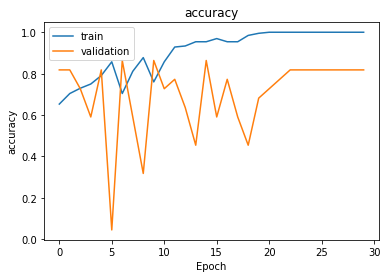

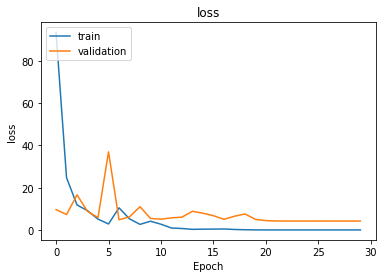

In [12]:
b = 32
train_history=model.fit(train_x,
                        train_y,
                        epochs=30,
                        validation_split=0.1,
                        batch_size=b,
                        shuffle=True)

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [13]:
loss, accuracy = model.evaluate(test_x, test_y)
print('test loss: ', loss)
print('test accuracy: ', accuracy)

3/3 [==============================] - 0s 27ms/step - loss: 1.8242 - accuracy: 0.9149
test loss:  1.824231743812561
test accuracy:  0.914893627166748


In [5]:
from keras.models import load_model

# # 保存训练好的model为hdf5文件
# model.save('/root/work/model/stad_surv_model.h5')  
# 重新加载模型
model = load_model('/root/work/model/stad_surv_model.h5')

In [6]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = test_y
y_pred = model.predict(test_x).astype(np.int64)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm, columns=['LTS','STS'], index=['LTS','STS'])
cm

,LTS,STS
LTS,70,0
STS,12,12


In [16]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(formatter={"float": "{: 0.2f}".format})
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


,LTS,STS
LTS,1.0,0.0
STS,0.5,0.5


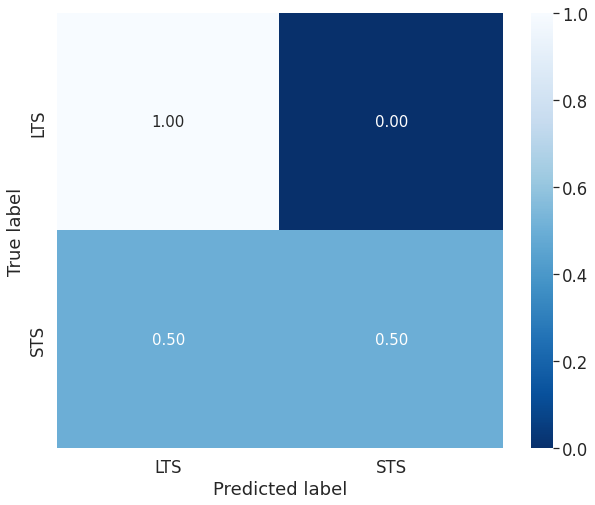

In [18]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))
plt.rc('font', size=15)
sns.heatmap(cm,cmap="Blues_r", annot=True , fmt='.2f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
import keras.backend as K
def Precision(model,test_x,test_y):
    y_pred = model.predict(test_x)
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))  # predicted positives
    pp = tf.cast(pp,dtype=tf.float64)
    precision = tp / (pp + K.epsilon())
    return precision

def Recall(model,test_x,test_y):
    y_pred = model.predict(test_x)
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(test_y, 0, 1)))  # possible positives
    pp = tf.cast(pp,dtype=tf.float64)
    recall = tp / (pp + K.epsilon())
    return recall

def F1(model,test_x,test_y):
    precision = Precision(model,test_x,test_y)
    recall = Recall(model,test_x,test_y)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [21]:
p = []
r = []
f1 = []
for i in range(2):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
    # p.append(Precision(model,test_x,test_y).numpy())
    # r.append(Recall(model,test_x,test_y).numpy())
    f1.append(Recall(model,test_x,test_y).numpy())

e_result = pd.DataFrame([p,r,f1], index=['Precision', 'Recall', 'F1'])
e_result

,0,1
Precision,NaN,NaN
Recall,NaN,NaN
F1,0.904762,0.909091


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [24]:
# Precision & Recall
my = []
rf = []
dt = []
svm = []
lr = []
knn = []
nb = []
for i in range(2):
    # my

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
    # # int -> onthot
    # train_y = kr.utils.to_categorical(train_y_t)
    # test_y = kr.utils.to_categorical(test_y_t)
    my.append(Precision(model,test_x,test_y).numpy())

    clf=RandomForestClassifier()  
    clf = clf.fit(train_x,train_y)
    rf.append(Precision(clf,test_x,test_y).numpy())

    clf2 = tree.DecisionTreeClassifier()
    clf2 = clf2.fit(train_x, train_y)
    dt.append(Precision(clf2,test_x,test_y).numpy())

    clf3 = SVC(kernel='linear')
    clf3.fit(train_x,train_y)
    y_pred = clf3.predict(test_x)
    svm.append(Precision(clf3,test_x,test_y).numpy())

    clf4 = linear_model.LogisticRegression(C=1e5)
    clf4.fit(train_x,train_y)
    lr.append(Precision(clf4,test_x,test_y).numpy())

    clf5 = KNeighborsClassifier()
    clf5.fit(train_x,train_y)
    y_pred = clf5.predict(test_x)
    knn.append(Precision(clf5,test_x,test_y).numpy())

    clf6 = GaussianNB()
    clf6 = clf6.fit(train_x,train_y)
    y_pred = clf6.predict(test_x)
    nb.append(Precision(clf6,test_x,test_y).numpy())

PR_result = pd.DataFrame([my,rf,dt,svm,lr,knn,nb], index=['my','rf','dt','svm','lr','knn','nb'])
PR_result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

,0,1
my,1.0,1.000000
rf,21.0,25.999999
dt,21.0,26.000000
svm,21.0,26.000000
lr,21.0,26.000000
knn,21.0,26.000000
nb,21.0,26.000000


In [124]:
clf=RandomForestClassifier()  
clf = clf.fit(train_x,train_y)
F1(clf,test_x,test_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


<tf.Tensor: shape=(), dtype=float64, numpy=3.652173865406427>

In [ ]:
# accuracy

my = []
rf = []
dt = []
svm = []
lr = []
knn = []
nb = []

for i in range(1):
    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
    print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

    # my
    my.append(F1(model,test_x,test_y).numpy())

    clf=RandomForestClassifier()  
    clf = clf.fit(train_x,train_y)
    rf.append(F1(clf,test_x,test_y).numpy())

    clf2 = tree.DecisionTreeClassifier()
    clf2 = clf2.fit(train_x, train_y)
    dt.append(F1(clf2,test_x,test_y).numpy())

    clf3 = SVC(kernel='rbf', probability=True)
    clf3.fit(train_x,train_y)
    svm.append(F1(clf3,test_x,test_y).numpy())

    clf4 = linear_model.LogisticRegression(C=1e5)
    clf4.fit(train_x,train_y)
    lr.append(F1(clf4,test_x,test_y).numpy())

    clf5 = KNeighborsClassifier()
    clf5.fit(train_x,train_y)
    knn.append(F1(clf5,test_x,test_y).numpy())

    clf6 = GaussianNB()
    clf6 = clf6.fit(train_x,train_y)
    nb.append(F1(clf6,test_x,test_y).numpy())

f1_result = pd.DataFrame([my,rf,dt,svm,lr,knn,nb], index=['my','rf','dt','svm','lr','knn','nb'])
f1_result

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

my = []
rf = []
dt = []
svm = []
lr = []
knn = []
nb = []

for i in range(10):
    # my
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
    print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
    loss, accuracy = model.evaluate(test_x, test_y)
    my.append(accuracy)

    clf=RandomForestClassifier()  
    clf = clf.fit(train_x,train_y)
    score1 = clf.score(test_x,test_y)
    rf.append(score1)

    clf2 = tree.DecisionTreeClassifier()
    clf2 = clf2.fit(train_x, train_y)
    score2 = clf2.score(test_x,test_y)
    dt.append(score2)

    clf3 = SVC(kernel='rbf', probability=True)
    clf3.fit(train_x,train_y)
    y_pred = clf3.predict(test_x)
    score3 = metrics.accuracy_score(test_y, y_pred)
    svm.append(score3)

    clf4 = linear_model.LogisticRegression(C=1e5)
    clf4.fit(train_x,train_y)
    score4 = clf4.score(test_x,test_y)
    lr.append(score4)

    clf5 = KNeighborsClassifier()
    clf5.fit(train_x,train_y)
    y_pred = clf5.predict(test_x)
    score5 = metrics.accuracy_score(test_y, y_pred)
    knn.append(score5)

    clf6 = GaussianNB()
    clf6 = clf6.fit(train_x,train_y)
    
    y_pred = clf6.predict(test_x)
    score6 = metrics.accuracy_score(test_y, y_pred)
    nb.append(score6)

evaluate_result = pd.DataFrame([my,rf,dt,svm,lr,knn,nb], index=['my','rf','dt','svm','lr','knn','nb'])
evaluate_result

(218, 12411) (94, 12411) (218, 1) (94, 1)
3/3 [==============================] - 0s 27ms/step - loss: 0.2984 - accuracy: 0.9681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

(218, 12411) (94, 12411) (218, 1) (94, 1)
3/3 [==============================] - 0s 26ms/step - loss: 0.4418 - accuracy: 0.9681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

(218, 12411) (94, 12411) (218, 1) (94, 1)
3/3 [==============================] - 0s 26ms/step - loss: 1.0048 - accuracy: 0.9681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(218, 12411) (94, 12411) (218, 1) (94, 1)
1/3 [=========>....................] - ETA: 0s - loss: 2.5574 - accuracy: 0.9375

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


3/3 [==============================] - 0s 27ms/step - loss: 1.3206 - accuracy: 0.9468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(218, 12411) (94, 12411) (218, 1) (94, 1)
1/3 [=========>....................] - ETA: 0s - loss: 9.6675e-06 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


3/3 [==============================] - 0s 26ms/step - loss: 1.0951 - accuracy: 0.9362


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

(218, 12411) (94, 12411) (218, 1) (94, 1)
3/3 [==============================] - 0s 27ms/step - loss: 1.0322 - accuracy: 0.9574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(218, 12411) (94, 12411) (218, 1) (94, 1)
1/3 [=========>....................] - ETA: 0s - loss: 0.3231 - accuracy: 0.9688

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


3/3 [==============================] - 0s 27ms/step - loss: 0.5509 - accuracy: 0.9681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(218, 12411) (94, 12411) (218, 1) (94, 1)
1/3 [=========>....................] - ETA: 0s - loss: 1.2293e-04 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


3/3 [==============================] - 0s 25ms/step - loss: 0.3656 - accuracy: 0.9681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

(218, 12411) (94, 12411) (218, 1) (94, 1)
3/3 [==============================] - 0s 24ms/step - loss: 0.6065 - accuracy: 0.9574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

(218, 12411) (94, 12411) (218, 1) (94, 1)
3/3 [==============================] - 0s 24ms/step - loss: 0.3999 - accuracy: 0.9681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/loca

,0,1,2,3,4,5,6,7,8,9
my,0.968085,0.968085,0.968085,0.946809,0.936170,0.957447,0.968085,0.968085,0.957447,0.968085
rf,0.734043,0.819149,0.787234,0.691489,0.702128,0.712766,0.723404,0.712766,0.723404,0.744681
dt,0.574468,0.617021,0.638298,0.638298,0.648936,0.617021,0.574468,0.627660,0.670213,0.723404
svm,0.723404,0.819149,0.787234,0.702128,0.691489,0.702128,0.723404,0.702128,0.734043,0.744681
lr,0.702128,0.744681,0.702128,0.670213,0.702128,0.712766,0.723404,0.648936,0.702128,0.702128
knn,0.734043,0.755319,0.776596,0.702128,0.691489,0.744681,0.734043,0.712766,0.734043,0.702128
nb,0.734043,0.659574,0.734043,0.659574,0.670213,0.638298,0.648936,0.659574,0.648936,0.553191


In [84]:
from sklearn.metrics import roc_curve
y_pred = model.predict(test_x).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [75]:
# rf
rf = RandomForestClassifier()
rf.fit(train_x, train_y.reshape(train_y.shape[0],))

y_pred_rf = rf.predict_proba(test_x)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_y, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# dt
clf2 = tree.DecisionTreeClassifier()
clf2.fit(train_x, train_y)

y_pred_dt = clf2.predict_proba(test_x)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(test_y, y_pred_dt)
auc_dt = auc(fpr_dt, tpr_dt)

# svm
clf3 = SVC(kernel='linear', probability=True)
clf3.fit(train_x,train_y)

y_pred_svm = clf3.predict_proba(test_x)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_y, y_pred_svm)
auc_svm = auc(fpr_svm, tpr_svm)

# lr
clf4 = linear_model.LogisticRegression()
clf4.fit(train_x,train_y)

y_pred_lr = clf4.predict_proba(test_x)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_y, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# knn
clf5 = KNeighborsClassifier()
clf5.fit(train_x,train_y)

y_pred_knn = clf5.predict_proba(test_x)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(test_y, y_pred_knn)
auc_knn = auc(fpr_knn, tpr_knn)

# nb
clf6 = GaussianNB()
clf6 = clf6.fit(train_x,train_y)

y_pred_nb = clf6.predict_proba(test_x)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(test_y, y_pred_nb)
auc_nb = auc(fpr_nb, tpr_nb)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_m

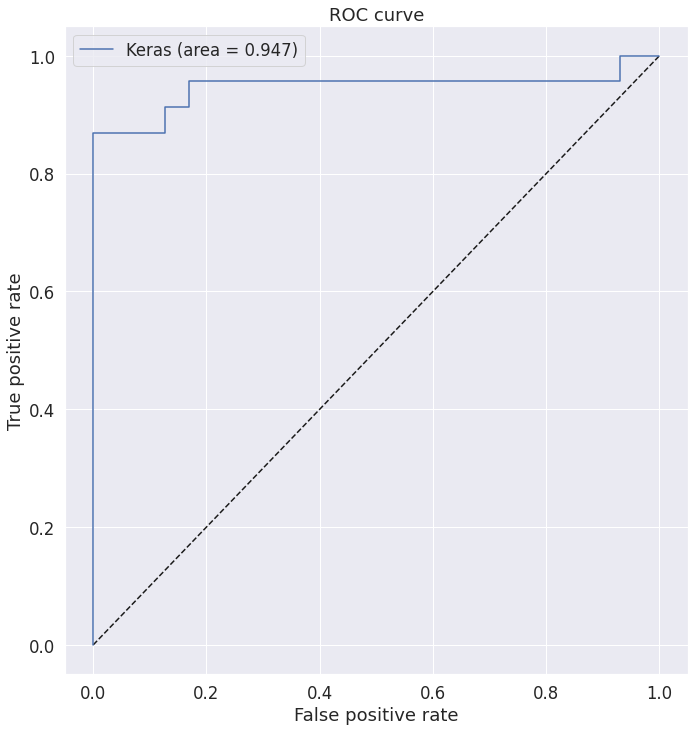

In [85]:
lw = 5
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.095, bottom=0.08, right=0.96, top=0.98)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.plot(fpr_dt, tpr_dt, label='DT (area = {:.3f})'.format(auc_dt))
# plt.plot(fpr_svm, tpr_svm, label='SVM (area = {:.3f})'.format(auc_svm))
# plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
# plt.plot(fpr_knn, tpr_knn, label='KNN (area = {:.3f})'.format(auc_knn))
# plt.plot(fpr_nb, tpr_nb, label='NB (area = {:.3f})'.format(auc_nb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.4, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [41]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()  
clf = clf.fit(train_x,train_y)
score1 = clf.score(test_x,test_y)
score1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.7553191489361702

In [42]:
from sklearn import tree
clf2 = tree.DecisionTreeClassifier()
clf2 = clf2.fit(train_x, train_y)
score2 = clf2.score(test_x,test_y)
score2

0.5531914893617021

In [28]:
import lime
import lime.lime_tabular

In [7]:
import tensorflow as tf
def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # # 2. Preprocess the interpolated images
    # interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [2]:
x = np.array(test_x.iloc[0])
img_size = x.shape
top_k = int(len(x)/100)

for num in range(len(test_x)):
    print(num)
    s = np.array(test_x.iloc[num]).reshape(1,test_x.shape[1])
    x = np.array(test_x.iloc[num])
    preds = model.predict(s)

    top_pred_idx = tf.argmax(preds[0])
    igrads = random_baseline_integrated_gradients(np.copy(x), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2)
    igrads = np.array(igrads).reshape(1,test_x.shape[1])

    if num == 0:
        igs = igrads
    else:
        igs = np.concatenate((igs, igrads), axis=0)
preds = model.predict(test_x)
preds_y = pd.DataFrame(np.where(preds>0.5, 1, 0), columns=['class'])

NameError: name 'np' is not defined

In [9]:
idx_0 = preds_y.index[preds_y['class']==0].to_list()
idx_1 = preds_y.index[preds_y['class']==1].to_list()

igs = pd.DataFrame(igs, columns=test_x.columns)

surv_0 = igs.loc[idx_0]
surv_1 = igs.loc[idx_1]

In [11]:
# LTS
row_mean = pd.DataFrame(surv_0.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/data/explanation/stad_surv0_igs_mean')

# STS
row_mean = pd.DataFrame(surv_1.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/data/explanation/stad_surv1_igs_mean')